In [2]:
import scanpy as sc
import scvi

/home/icb/daniel.strobl/conda_scib/envs/scIB-python-3/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [11]:
def runScanvi(adata, batch, labels, hvg=False):
    # Use non-normalized (count) data for scanvi!
    
    # Check for counts data layer
    if 'counts' not in adata.layers:
        raise TypeError('Adata does not contain a `counts` layer in `adata.layers[`counts`]`')

    from scvi.models import VAE, SCANVI
    from scvi.inference import UnsupervisedTrainer, SemiSupervisedTrainer
    from sklearn.preprocessing import LabelEncoder
    from scvi.dataset import AnnDatasetFromAnnData
    import numpy as np
    
    # STEP 1: prepare the data
    net_adata = adata.copy()
    net_adata.X = adata.layers['counts']
    del net_adata.layers['counts']
    # Ensure that the raw counts are not accidentally used
    del net_adata.raw # Note that this only works from anndata 0.7

    # Define batch indices
    le = LabelEncoder()
    net_adata.obs['batch_indices'] = le.fit_transform(net_adata.obs[batch].values)
    net_adata.obs['labels'] = le.fit_transform(net_adata.obs[labels].values)

    net_adata = AnnDatasetFromAnnData(net_adata)

    print("scANVI dataset object with {} batches and {} cell types".format(net_adata.n_batches, net_adata.n_labels))

    if hvg is True:
        # this also corrects for different batches by default
        net_adata.subsample_genes(2000, mode="seurat_v3")

    # # Defaults from SCVI github tutorials scanpy_pbmc3k and harmonization
    n_epochs_scVI = np.min([round((20000/adata.n_obs)*400), 400]) #400
    n_epochs_scANVI = np.min([10, np.max([2, round(n_epochs_scVI / 3.)])])
    n_latent=30
    n_hidden=128
    n_layers=2


    # STEP 2: RUN scVI to initialize scANVI

    vae = VAE(
        net_adata.nb_genes,
        reconstruction_loss='nb',
        n_batch=net_adata.n_batches,
        n_latent=n_latent,
        n_hidden=n_hidden,
        n_layers=n_layers,
    )

    trainer = UnsupervisedTrainer(
        vae,
        net_adata,
        train_size=1.0,
        use_cuda=True,
    )

    trainer.train(n_epochs=n_epochs_scVI, lr=1e-3)

    # STEP 3: RUN scANVI

    scanvi = SCANVI(net_adata.nb_genes, net_adata.n_batches, net_adata.n_labels,
                          n_hidden=n_hidden, n_latent=n_latent, n_layers=n_layers, dispersion='gene')
    scanvi.load_state_dict(trainer.model.state_dict(), strict=False)

    # use default parameter from semi-supervised trainer class
    trainer_scanvi = SemiSupervisedTrainer(scanvi, net_adata)
    # use all cells as labelled set
    trainer_scanvi.labelled_set = trainer_scanvi.create_posterior(trainer_scanvi.model, net_adata, indices=np.arange(len(net_adata)))
    # put one cell in the unlabelled set
    trainer_scanvi.unlabelled_set = trainer_scanvi.create_posterior(indices=[0])
    trainer_scanvi.train(n_epochs=n_epochs_scANVI)

    # extract info from posterior
    scanvi_full = trainer_scanvi.create_posterior(trainer_scanvi.model, net_adata, indices=np.arange(len(net_adata)))
    latent, _, _ = scanvi_full.sequential().get_latent()

    adata.obsm['X_emb'] = latent

    return adata#, scanvi_full.sequential(), trainer_scanvi

In [1]:
import anndata

In [2]:
anndata.__version__

'0.7.4'

In [ ]:
pip install anndata==0.6.22

In [ ]:
import scIB

In [9]:
import scvi.models

In [13]:
adata = sc.read('/storage/groups/ml01/workspace/scIB/simulations_1_1/sim1_1_norm.h5ad')

In [9]:
adata

AnnData object with n_obs × n_vars = 12097 × 9979 
    obs: 'Cell', 'Batch', 'Group', 'ExpLibSize', 'sum', 'detected', 'percent_top_50', 'percent_top_100', 'percent_top_200', 'percent_top_500', 'total', 'Discard', 'size_factors'
    var: 'Gene', 'BaseGeneMean', 'OutlierFactor', 'GeneMean', 'BatchFacBatch1', 'BatchFacBatch2', 'BatchFacBatch3', 'BatchFacBatch4', 'BatchFacBatch5', 'BatchFacBatch6', 'DEFacGroup1', 'DEFacGroup2', 'DEFacGroup3', 'DEFacGroup4', 'DEFacGroup5', 'DEFacGroup6', 'DEFacGroup7', 'mean', 'detected'
    layers: 'counts'

In [14]:
integrated2 = runScanvi(adata, 'Batch', 'Group')

[2020-08-27 19:27:12,665] INFO - scvi.dataset.anndataset | Dense size under 1Gb, casting to dense format (np.ndarray).
[2020-08-27 19:27:13,276] WARNING - scvi.dataset.dataset | detected is a protected attribute or already exists as a cell attribute and cannot be set with this name in initialize_gene_attribute, changing name to detected_gene and setting
[2020-08-27 19:27:13,277] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-08-27 19:27:13,280] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-08-27 19:27:15,712] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-08-27 19:27:15,928] INFO - scvi.dataset.dataset | Downsampled from 12097 to 12097 cells
scANVI dataset object with 6 batches and 7 cell types
[2020-08-27 19:27:16,006] INFO - scvi.inference.inference | KL warmup for 400 epochs
training: 100%|██████████| 400/400 [1:16:51<00:00, 11.53s/it]
[2020-08-27 20:44:07,423] INFO - scvi.inference.inference | KL warmup phase ex

In [15]:
integrated2

(AnnData object with n_obs × n_vars = 12097 × 9979 
     obs: 'Cell', 'Batch', 'Group', 'ExpLibSize', 'sum', 'detected', 'percent_top_50', 'percent_top_100', 'percent_top_200', 'percent_top_500', 'total', 'Discard', 'size_factors'
     var: 'Gene', 'BaseGeneMean', 'OutlierFactor', 'GeneMean', 'BatchFacBatch1', 'BatchFacBatch2', 'BatchFacBatch3', 'BatchFacBatch4', 'BatchFacBatch5', 'BatchFacBatch6', 'DEFacGroup1', 'DEFacGroup2', 'DEFacGroup3', 'DEFacGroup4', 'DEFacGroup5', 'DEFacGroup6', 'DEFacGroup7', 'mean', 'detected'
     obsm: 'X_emb'
     layers: 'counts',
 <scvi.inference.annotation.SemiSupervisedTrainer at 0x7f523f49ce10>)

In [22]:
sc.write('scanvi_integrated.h5ad', integrated2)

In [5]:
integrated2 = sc.read('scanvi_integrated.h5ad')

In [15]:
sc.pp.neighbors(integrated2, use_rep='X_emb')

In [16]:
sc.tl.umap(integrated2)

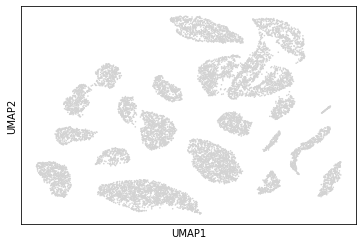

In [8]:
sc.pl.umap(integrated2)

In [16]:
scIB.pp.reduce_data(integrated2, use_rep='X_emb', pca=False)

NameError: name 'scIB' is not defined

In [77]:
import matplotlib.pyplot as plt

In [79]:
sc.pl.umap(adata)
plt.show()

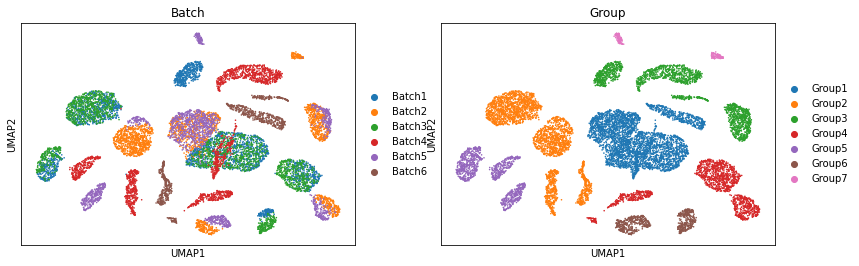

In [17]:
sc.pl.umap(integrated2, color=['Batch', 'Group'])